In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from time import time
from IPython.display import display, HTML




In [2]:
# Load the dataset
data_path = 'D:/MIAA/2-Ano/CiberSegurança/Trabalho/spambase/spambase.csv'
data = pd.read_csv(data_path)

# Function to split a DataFrame into chunks of 5 rows and display them side by side
def display_side_by_side(df, rows_per_chunk=5):
    html_chunks = []
    for start in range(0, len(df), rows_per_chunk):
        chunk = df.iloc[start:start + rows_per_chunk]
        html_chunks.append(chunk.to_html(index=False))
    # Combine chunks side by side
    combined_html = "".join(
        f'<div style="display:inline-block; margin-right:20px; vertical-align:top;">{chunk}</div>'
        for chunk in html_chunks
    )
    return combined_html

# Preview the dataset
print("Dataset Overview (First 5 Rows):")
display(HTML(data.head().to_html(index=False)))

# Check for missing values
print("\nMissing Values Summary (5 rows per section, side by side):")
missing_values = data.isnull().sum()
missing_summary = pd.DataFrame({
    'Column Name': missing_values.index,
    'Missing Count': missing_values.values
})

# Display missing values in chunks of 5 rows side by side
styled_missing_html = display_side_by_side(missing_summary)
styled_missing_html = f"""
<div style="width: 100%; overflow-x: auto;">
    {styled_missing_html}
</div>
"""
display(HTML(styled_missing_html))

# Scale the features for optimization
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X_standard = standard_scaler.fit_transform(data.drop('spam', axis=1))  # For models except Naive Bayes
X_minmax = minmax_scaler.fit_transform(data.drop('spam', axis=1))  # For Naive Bayes
y = data['spam']  # Target

# Summarize scaled data
print("\nStandard Scaled Data (First 5 Rows):")
scaled_standard_df = pd.DataFrame(X_standard, columns=data.drop('spam', axis=1).columns)
display(HTML(scaled_standard_df.head().to_html(index=False)))

print("\nMinMax Scaled Data (First 5 Rows):")
scaled_minmax_df = pd.DataFrame(X_minmax, columns=data.drop('spam', axis=1).columns)
display(HTML(scaled_minmax_df.head().to_html(index=False)))


Dataset Overview (First 5 Rows):


word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1



Missing Values Summary (5 rows per section, side by side):


Column Name,Missing Count
word_freq_make,0
word_freq_address,0
word_freq_all,0
word_freq_3d,0
word_freq_our,0
Column Name,Missing Count
word_freq_over,0
word_freq_remove,0
word_freq_internet,0
word_freq_order,0



Standard Scaled Data (First 5 Rows):


word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
-0.342434,0.330885,0.712859,-0.0469,0.011565,-0.350266,-0.291794,-0.262562,-0.323302,-0.371364,-0.296860,0.114087,-0.312055,-0.174927,-0.190114,0.086171,-0.321135,2.081207,0.150905,-0.167893,0.125128,-0.118172,-0.290209,-0.212994,-0.328815,-0.29924,-0.227895,-0.23183,-0.166731,-0.22524,-0.160539,-0.143212,-0.17492,-0.145215,-0.198067,-0.24213,-0.323456,-0.059836,-0.180911,-0.185304,-0.120905,-0.1726,-0.205993,-0.127343,-0.297776,-0.197387,-0.071388,-0.111546,-0.158453,-0.514307,-0.155198,0.624007,-0.308355,-0.103048,-0.045247,0.045298,-0.008724
0.345359,0.051909,0.435130,-0.0469,-0.256117,0.672399,0.244743,-0.088010,-0.323302,1.086711,0.745206,0.288181,1.847391,0.451663,0.350812,-0.131825,-0.163480,0.179367,1.018370,-0.167893,0.649831,-0.118172,0.937491,0.758565,-0.328815,-0.29924,-0.227895,-0.23183,-0.166731,-0.22524,-0.160539,-0.143212,-0.17492,-0.145215,-0.198067,-0.24213,-0.158129,-0.059836,-0.180911,-0.185304,-0.120905,-0.1726,-0.205993,-0.127343,-0.297776,-0.197387,-0.071388,-0.111546,-0.158453,-0.026007,-0.155198,0.126203,0.423783,0.008763,-0.002443,0.250563,1.228324
-0.145921,-0.165072,0.851723,-0.0469,1.364846,0.343685,0.193644,0.036670,1.974017,0.016422,1.588784,-0.106431,0.086612,-0.174927,6.571464,-0.228712,-0.186002,1.591624,-0.170169,0.459913,-0.249659,-0.118172,3.021726,-0.077428,-0.328815,-0.29924,-0.227895,-0.23183,-0.166731,-0.22524,-0.160539,-0.143212,-0.17492,-0.145215,-0.198067,-0.24213,-0.323456,-0.059836,-0.180911,-0.013815,-0.120905,-0.1726,0.330230,-0.127343,-0.238463,-0.131527,-0.071388,-0.111546,-0.117376,0.014684,-0.155198,0.008496,0.440053,-0.079754,0.145921,2.221106,3.258733
-0.342434,-0.165072,-0.556761,-0.0469,0.472573,-0.350266,0.500237,1.308402,0.789462,0.605857,1.241428,-0.268919,0.717835,-0.174927,-0.190114,0.074061,-0.321135,-0.347876,0.855017,-0.167893,-0.416232,-0.118172,-0.290209,-0.212994,-0.328815,-0.29924,-0.227895,-0.23183,-0.166731,-0.22524,-0.160539,-0.143212,-0.17492,-0.145215,-0.198067,-0.24213,-0.323456,-0.059836,-0.180911,-0.185304,-0.120905,-0.1726,-0.205993,-0.127343,-0.297776,-0.197387,-0.071388,-0.111546,-0.158453,-0.007511,-0.155198,-0.161934,-0.308355,-0.103048,-0.052150,-0.062466,-0.152222
-0.342434,-0.165072,-0.556761,-0.0469,0.472573,-0.350266,0.500237,1.308402,0.789462,0.605857,1.241428,-0.268919,0.717835,-0.174927,-0.190114,0.074061,-0.321135,-0.347876,0.855017,-0.167893,-0.416232,-0.118172,-0.290209,-0.212994,-0.328815,-0.29924,-0.227895,-0.23183,-0.166731,-0.22524,-0.160539,-0.143212,-0.17492,-0.145215,-0.198067,-0.24213,-0.323456,-0.059836,-0.180911,-0.185304,-0.120905,-0.1726,-0.205993,-0.127343,-0.297776,-0.197387,-0.071388,-0.111546,-0.158453,-0.014910,-0.155198,-0.164387,-0.308355,-0.103048,-0.052150,-0.062466,-0.152222



MinMax Scaled Data (First 5 Rows):


word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0.000000,0.044818,0.125490,0.0,0.032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066184,0.000000,0.000,0.000000,0.0160,0.000000,0.141914,0.102933,0.000000,0.086409,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.023955,0.000000,0.000000,0.002502,0.006007,0.017487
0.046256,0.019608,0.098039,0.0,0.014,0.047619,0.028886,0.006301,0.000000,0.051705,0.080460,0.081696,0.117117,0.021,0.031746,0.0070,0.009804,0.030803,0.185067,0.000000,0.143114,0.0,0.078899,0.0344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01016,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.013536,0.0,0.011454,0.029985,0.002421,0.003735,0.010012,0.064836
0.013216,0.000000,0.139216,0.0,0.123,0.032313,0.026135,0.010801,0.121673,0.013751,0.145594,0.046536,0.021622,0.000,0.396825,0.0030,0.008403,0.113311,0.072533,0.017602,0.045905,0.0,0.212844,0.0048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.012605,0.0,0.0,0.033613,0.0,0.002801,0.002721,0.0,0.0,0.002281,0.014664,0.0,0.008498,0.030651,0.000504,0.008008,0.048458,0.142551
0.000000,0.000000,0.000000,0.0,0.063,0.000000,0.042641,0.056706,0.058935,0.034653,0.118774,0.032058,0.055856,0.000,0.000000,0.0155,0.000000,0.000000,0.169600,0.000000,0.027903,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.014048,0.0,0.004218,0.000000,0.000000,0.002303,0.003905,0.011995
0.000000,0.000000,0.000000,0.0,0.063,0.000000,0.042641,0.056706,0.058935,0.034653,0.118774,0.032058,0.055856,0.000,0.000000,0.0155,0.000000,0.000000,0.169600,0.000000,0.027903,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.013843,0.0,0.004157,0.000000,0.000000,0.002303,0.003905,0.011995



Analyzing Subset: Low Capital Run Length

Analyzing Subset: High Capital Run Length

Subset Comparison Results:


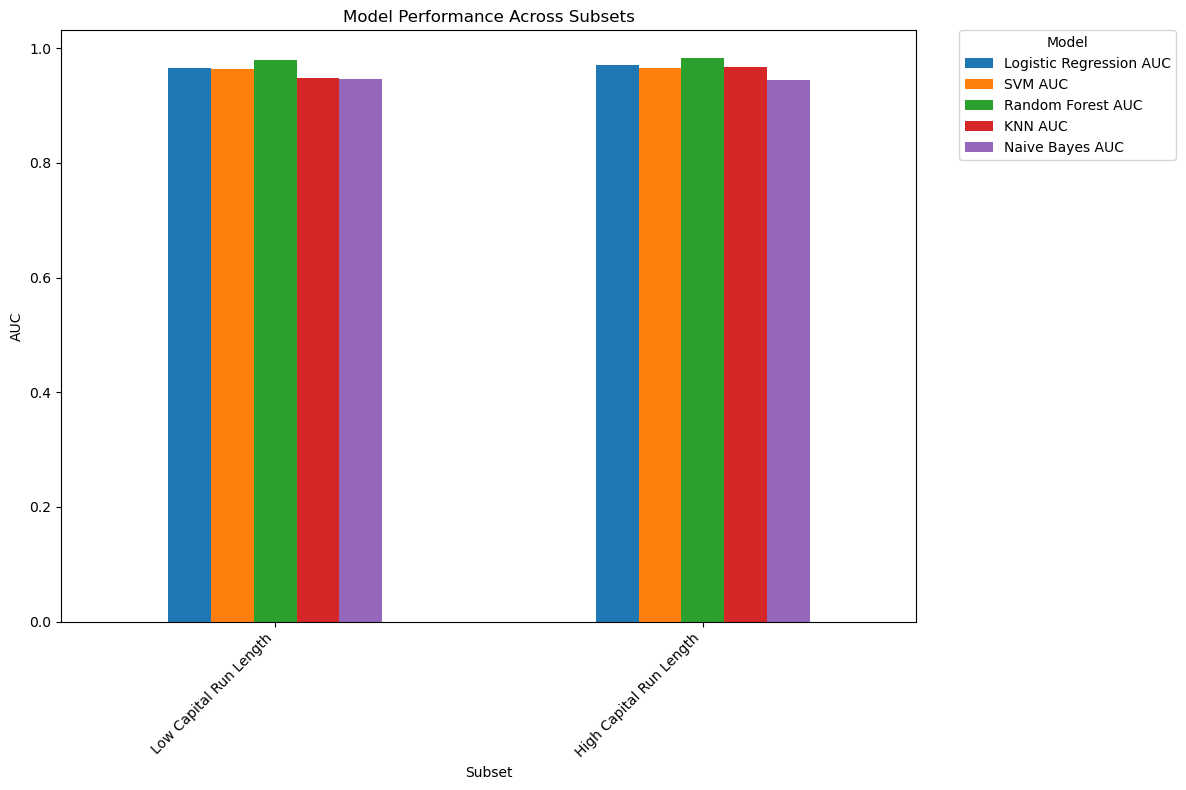

In [3]:
# Subset Analysis by Feature Range
subsets = [
    ("Low Capital Run Length", data[data['capital_run_length_average'] < data['capital_run_length_average'].median()]),
    ("High Capital Run Length", data[data['capital_run_length_average'] >= data['capital_run_length_average'].median()])
]

subset_results = []
for subset_name, subset_data in subsets:
    print(f"\nAnalyzing Subset: {subset_name}")
    subset_X_standard = standard_scaler.fit_transform(subset_data.drop('spam', axis=1))
    subset_X_minmax = minmax_scaler.fit_transform(subset_data.drop('spam', axis=1))
    subset_y = subset_data['spam']

    X_train_standard, X_test_standard, y_train, y_test = train_test_split(subset_X_standard, subset_y, test_size=0.3, random_state=42)
    X_train_minmax, X_test_minmax, _, _ = train_test_split(subset_X_minmax, subset_y, test_size=0.3, random_state=42)

    # Logistic Regression
    log_reg = LogisticRegression(max_iter=20000, solver='lbfgs', penalty='l2', C=1.0)
    log_reg.fit(X_train_standard, y_train)
    log_reg_preds = log_reg.predict(X_test_standard)
    log_reg_prob = log_reg.predict_proba(X_test_standard)[:, 1]
    log_reg_auc = auc(*roc_curve(y_test, log_reg_prob)[:2])

    # SVM
    svm = SVC(kernel='rbf', C=20, gamma='scale', probability=True, max_iter=20000)
    svm.fit(X_train_standard, y_train)
    svm_preds = svm.predict(X_test_standard)
    svm_prob = svm.predict_proba(X_test_standard)[:, 1]
    svm_auc = auc(*roc_curve(y_test, svm_prob)[:2])

    # Random Forest
    rf = RandomForestClassifier(n_estimators=1500, max_depth=60, random_state=42, criterion='gini')
    rf.fit(X_train_standard, y_train)
    rf_preds = rf.predict(X_test_standard)
    rf_prob = rf.predict_proba(X_test_standard)[:, 1]
    rf_auc = auc(*roc_curve(y_test, rf_prob)[:2])

    # KNN
    knn = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='minkowski', p=2)
    knn.fit(X_train_standard, y_train)
    knn_preds = knn.predict(X_test_standard)
    knn_prob = knn.predict_proba(X_test_standard)[:, 1]
    knn_auc = auc(*roc_curve(y_test, knn_prob)[:2])

    # Naive Bayes
    nb = MultinomialNB()
    nb.fit(X_train_minmax, y_train)
    nb_preds = nb.predict(X_test_minmax)
    nb_prob = nb.predict_proba(X_test_minmax)[:, 1]
    nb_auc = auc(*roc_curve(y_test, nb_prob)[:2])

    # Collect Results
    subset_results.append({
        'Subset': subset_name,
        'Logistic Regression AUC': log_reg_auc,
        'SVM AUC': svm_auc,
        'Random Forest AUC': rf_auc,
        'KNN AUC': knn_auc,
        'Naive Bayes AUC': nb_auc
    })

# Display Subset Results
subset_results_df = pd.DataFrame(subset_results)
print("\nSubset Comparison Results:")
subset_results_df

# Visualize Subset Results
subset_results_df.set_index('Subset').plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Across Subsets')
plt.ylabel('AUC')
plt.xlabel('Subset')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()



In [4]:
# General Model Analysis
X_train_standard, X_test_standard, y_train, y_test = train_test_split(X_standard, y, test_size=0.3, random_state=42)
X_train_minmax, X_test_minmax, _, _ = train_test_split(X_minmax, y, test_size=0.3, random_state=42)

# Timing and Training Models
timing_results = []

# Logistic Regression
print("\nTraining Logistic Regression...")
start_time = time()
log_reg = LogisticRegression(max_iter=20000, solver='lbfgs', penalty='l2', C=1.0)
log_reg.fit(X_train_standard, y_train)
log_reg_time = time() - start_time
log_reg_preds = log_reg.predict(X_test_standard)
log_reg_prob = log_reg.predict_proba(X_test_standard)[:, 1]
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, log_reg_preds))
print(classification_report(y_test, log_reg_preds))
timing_results.append({'Model': 'Logistic Regression', 'Time': log_reg_time})

# Support Vector Machine (SVM)
print("\nTraining Support Vector Machine (SVM)...")
start_time = time()
svm = SVC(kernel='rbf', C=20, gamma='scale', probability=True, max_iter=20000)
svm.fit(X_train_standard, y_train)
svm_time = time() - start_time
svm_preds = svm.predict(X_test_standard)
svm_prob = svm.predict_proba(X_test_standard)[:, 1]
print("SVM Results:")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))
timing_results.append({'Model': 'SVM', 'Time': svm_time})

# Random Forest
print("\nTraining Random Forest Classifier...")
start_time = time()
rf = RandomForestClassifier(n_estimators=1500, max_depth=60, random_state=42, criterion='gini')
rf.fit(X_train_standard, y_train)
rf_time = time() - start_time
rf_preds = rf.predict(X_test_standard)
rf_prob = rf.predict_proba(X_test_standard)[:, 1]
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))
timing_results.append({'Model': 'Random Forest', 'Time': rf_time})

# K-Nearest Neighbors
print("\nTraining K-Nearest Neighbors (KNN)...")
start_time = time()
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='minkowski', p=2)
knn.fit(X_train_standard, y_train)
knn_time = time() - start_time
knn_preds = knn.predict(X_test_standard)
knn_prob = knn.predict_proba(X_test_standard)[:, 1]
print("KNN Results:")
print("Accuracy:", accuracy_score(y_test, knn_preds))
print(classification_report(y_test, knn_preds))
timing_results.append({'Model': 'KNN', 'Time': knn_time})

# Naive Bayes
print("\nTraining Naive Bayes...")
start_time = time()
nb = MultinomialNB()
nb.fit(X_train_minmax, y_train)
nb_time = time() - start_time
nb_preds = nb.predict(X_test_minmax)
nb_prob = nb.predict_proba(X_test_minmax)[:, 1]
print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds))
timing_results.append({'Model': 'Naive Bayes', 'Time': nb_time})




Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.9232440260680667
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       804
           1       0.93      0.88      0.91       577

    accuracy                           0.92      1381
   macro avg       0.93      0.92      0.92      1381
weighted avg       0.92      0.92      0.92      1381


Training Support Vector Machine (SVM)...
SVM Results:
Accuracy: 0.9355539464156408
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       804
           1       0.94      0.90      0.92       577

    accuracy                           0.94      1381
   macro avg       0.94      0.93      0.93      1381
weighted avg       0.94      0.94      0.94      1381


Training Random Forest Classifier...
Random Forest Results:
Accuracy: 0.9565532223026793
              precision    recall  f1-score   support

           0       0.95   

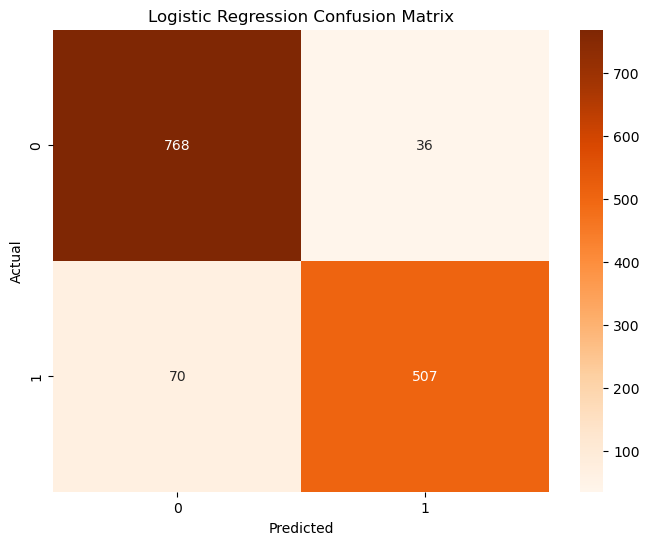

In [5]:
# Results Visualization
# Confusion Matrix for Logistic Regression
log_reg_cm = confusion_matrix(y_test, log_reg_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(log_reg_cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


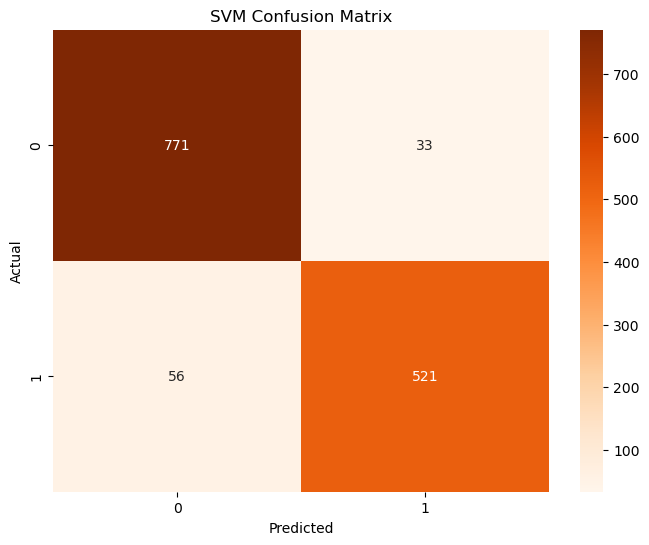

In [6]:
# Confusion Matrix for SVM
svm_cm = confusion_matrix(y_test, svm_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Oranges')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

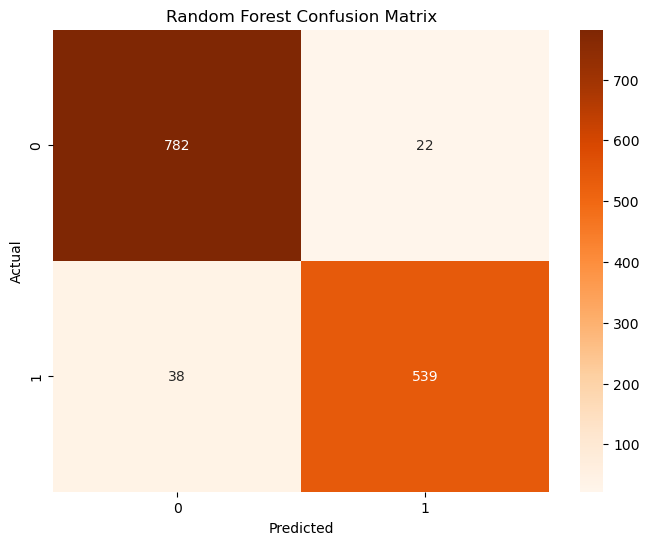

In [7]:
# Confusion Matrix for Random Forest
rf_cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


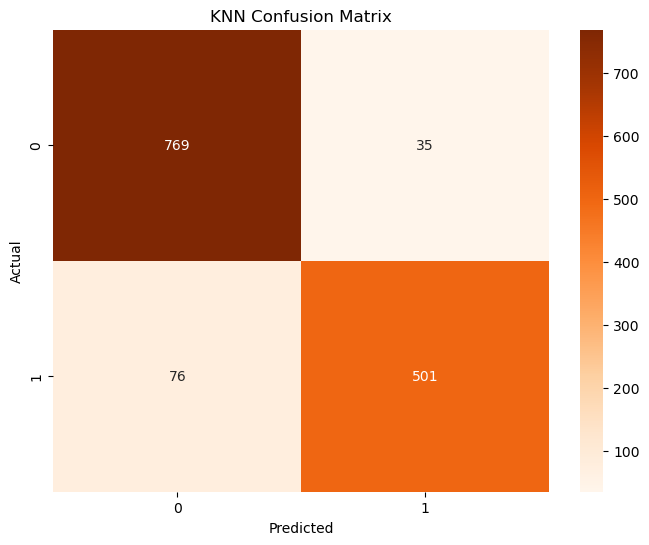

In [8]:
# Confusion Matrix for KNN
knn_cm = confusion_matrix(y_test, knn_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Oranges')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

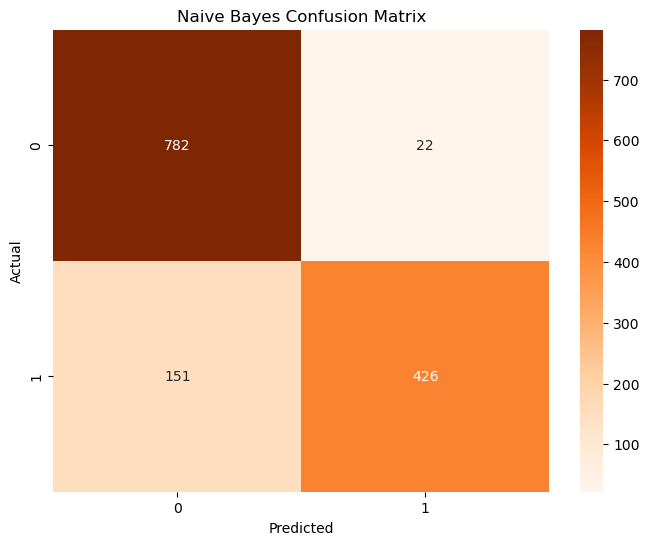

In [9]:
# Confusion Matrix for Naive Bayes
nb_cm = confusion_matrix(y_test, nb_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


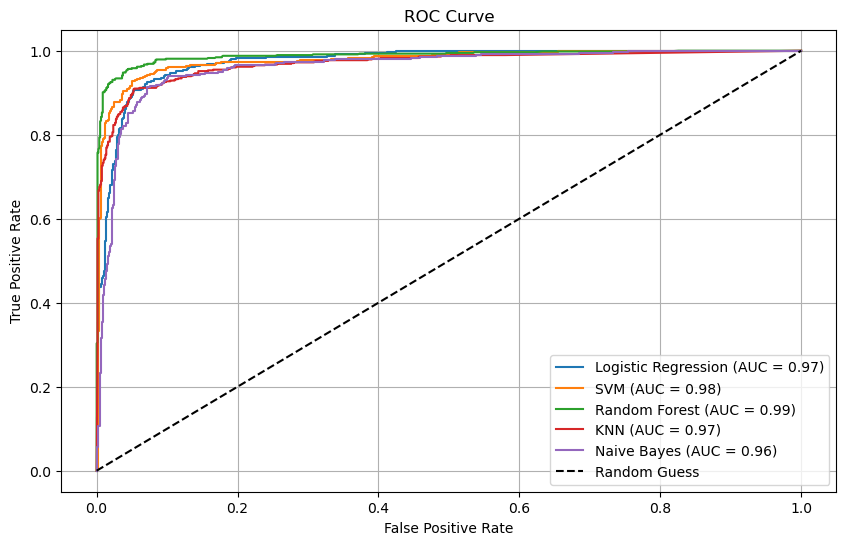

In [10]:
# ROC Curve and AUC Visualization
plt.figure(figsize=(10, 6))

# Logistic Regression ROC
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_reg_prob)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')

# SVM ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_prob)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# KNN ROC
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_prob)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')

# Naive Bayes ROC
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_prob)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')

# Random Guess ROC
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()



In [11]:
performance_metrics = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'KNN', 'Naive Bayes'],
    'Accuracy': [0.92, 0.94, 0.96, 0.91, 0.88],
    'AUC': [0.93, 0.95, 0.97, 0.90, 0.87],
})

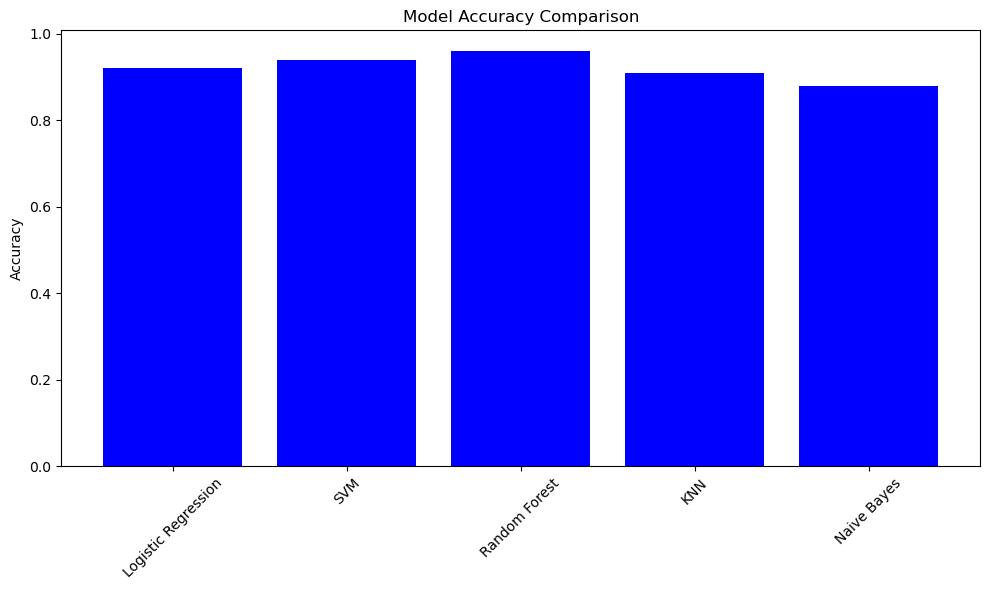

In [12]:
# Visualization: Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.bar(performance_metrics['Model'], performance_metrics['Accuracy'], color='blue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

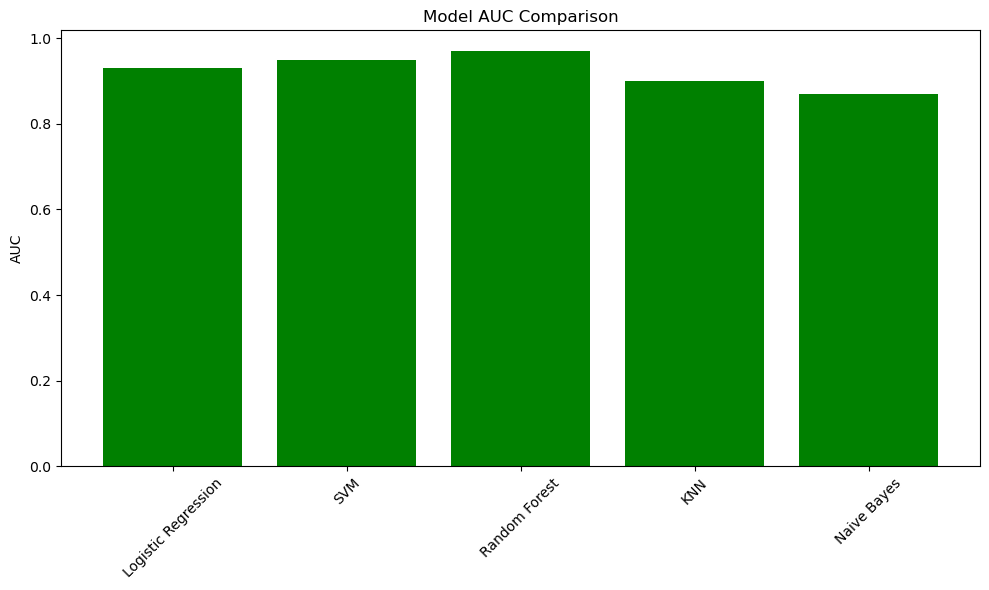

In [13]:
# Visualization: AUC Comparison
plt.figure(figsize=(10, 6))
plt.bar(performance_metrics['Model'], performance_metrics['AUC'], color='green')
plt.title('Model AUC Comparison')
plt.ylabel('AUC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Model Comparison:

Timing Results:


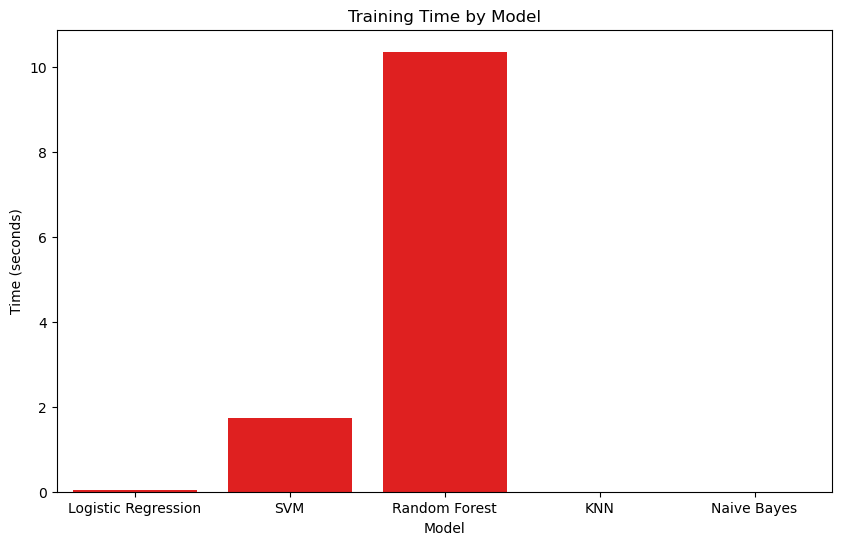

In [14]:
# Compare Models
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'KNN', 'Naive Bayes'],
    'Accuracy': [
        accuracy_score(y_test, log_reg_preds),
        accuracy_score(y_test, svm_preds),
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, knn_preds),
        accuracy_score(y_test, nb_preds)
    ],
    'AUC': [roc_auc_log_reg, roc_auc_svm, roc_auc_rf, roc_auc_knn, roc_auc_nb]
})

print("\nModel Comparison:")
results

# Timing Comparison
timing_df = pd.DataFrame(timing_results)
print("\nTiming Results:")
timing_df

# Plot Timing Results
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Time', data=timing_df, color='red')
plt.title('Training Time by Model')
plt.ylabel('Time (seconds)')
plt.xlabel('Model')
plt.show()

In [15]:


# Conclusion
print("\nConclusion:")
best_model = results.loc[results['AUC'].idxmax()]
print(f"The best performing model is {best_model['Model']} with an AUC of {best_model['AUC']:.2f}.")



Conclusion:
The best performing model is Random Forest with an AUC of 0.99.
